In [27]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import precision_recall_curve

from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import FunctionTransformer, StandardScaler

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,ConfusionMatrixDisplay
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import precision_recall_fscore_support
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from skimage.transform import resize
from skimage.feature import canny

from scipy.ndimage import find_objects, label
import matplotlib as mpl


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score

In [38]:
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
X = mnist["data"]
y = mnist["target"].astype(np.uint8)

# Convert X to a NumPy array if it's a DataFrame
#X_np = X.values if hasattr(X, "values") else X

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
X_train_normalized = X_train / 255.0
X_test_normalized = X_test / 255.0

In [ ]:
# Plotting the features of the X data, it looks like a 5.
some_digit = X_train_normalized[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
# plt.axis("off")
print(some_digit_image)

Find the Bounding Box for Each Image: find the coordinates of the smallest rectangle that can fully contain the digit (or object of interest). examining the pixel values to find the top, bottom, left, and right edges that contain the digit.

In [15]:
import numpy as np
from scipy.ndimage import find_objects, label

def center_image_by_bounding_box2(image):
    # Threshold the image to find non-zero pixels (assuming the background is black)
  #  thresholded = image > 0
 
    #print("label(image):", label(image))  # Debugging line to see how many objects were found
    # Label connected components
    labeled_array, num_features = label(image)
   # print("Number of features:", num_features)  # Debugging line to see how many objects were found
    
    # Find objects slices
    slices = find_objects(labeled_array)
    #print("Slices found:", slices)  # Debugging line to inspect the slices
    
    if slices:
        for obj_slice in slices:
           
            # Ensure there are two dimensions (y and x)
            if len(obj_slice) == 2:
                slice_y, slice_x = obj_slice
                bbox_center = ((slice_x.stop + slice_x.start) / 2, (slice_y.stop + slice_y.start) / 2)
                image_center = np.array(image.shape) / 2
                shift = image_center - np.array(bbox_center)
                # Create an empty canvas to place the centered image
                centered_image = np.zeros_like(image)
                # Calculate new bounding box position
                new_x = slice(int(slice_x.start + shift[0]), int(slice_x.stop + shift[0]))
                new_y = slice(int(slice_y.start + shift[1]), int(slice_y.stop + shift[1]))
                # Place the image in the new position
                centered_image[new_y, new_x] = image[slice_y, slice_x]
                return centered_image
    else:
        print("No objects found. Check the thresholding and input image.")
        return image  # Return the original image or handle the case as needed


Number of features: 1


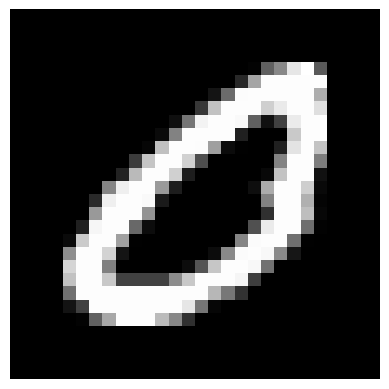

In [16]:
# Example: Reshaping a flattened 28x28 MNIST image back to 2D
flattened_image = X_train_normalized[0]  # Assuming this is a flattened image with 784 elements
image_2d = flattened_image.reshape((28, 28))



image_centered = center_image_by_bounding_box2(image_2d)

import matplotlib.pyplot as plt

# Assuming 'image_centered' is your processed image
plt.imshow(image_centered, cmap='gray')
plt.axis('off') # Hide the axis to focus on the image
plt.show()



In [19]:

def dilate_image(image, iterations=1):
    """
    Dilate the image to make digits thicker.
    startade med iteration = 1 och kernerl = 2,2
    :param image: Input image as a numpy array.
    :param iterations: How many times the dilation operation is applied.
    """
    kernel = np.ones((3,3), np.uint8)  # Define the kernel for dilation; you can adjust the size for different effects.
    dilated_image = cv2.dilate(image, kernel, iterations=iterations)  # Apply dilation
    return dilated_image


In [20]:
def refine_digits(image, kernel_size=(2,2), dilation_iterations=1, erosion_iterations=1):
    kernel = np.ones(kernel_size, np.uint8)
    # Dilate the image
    image_dilated = cv2.dilate(image, kernel, iterations=dilation_iterations)
    # Erode the image
    image_eroded = cv2.erode(image_dilated, kernel, iterations=erosion_iterations)
    return image_eroded

In [62]:
from PIL import Image
import numpy as np
import cv2  # Import OpenCV

def load_image2(path):
    # Load the image and convert it to grayscale
    image = Image.open(path).convert('L')
    
    # Resize the image to 28x28 pixels
    image_resized = image.resize((28, 28))
    image_np = np.array(image_resized)
   
    max_old = np.max(image_np)
    min_old = np.min(image_np)
  
   


   
    min_old, max_old = np.min(image_np), np.max(image_np)
    min_new, max_new = 0, 255

    # Scale the image from the old range to the new range (0-255)
    new_image = (image_np - min_old) / (max_old - min_old) * (max_new - min_new) + min_new

    # Clip to ensure values remain within the 0-255 range and convert to uint8
    new_image = np.clip(new_image, 0, 255).astype(np.uint8)

    # Inversion and initial thresholding
    image_inverted = 255 - new_image
    _, image_thresholded = cv2.threshold(image_inverted, 0, 255, cv2.THRESH_TOZERO + cv2.THRESH_OTSU)

    # Custom thresholding to enhance whiteness
    threshold_value = 165 
    image_enhanced_whiteness = np.where(image_thresholded > threshold_value, 255, image_thresholded).astype(np.uint8)

   
    image_dilated = dilate_image(image_enhanced_whiteness, iterations=1)  # You can adjust iterations based on the desired thickness
  

    image_centered = center_image_by_bounding_box2(image_dilated)

    image_normalized = image_centered / 255.0
    

    # Flatten the centered (and possibly normalized) image for model input
    
    image_flattened_reshaped = image_normalized.flatten().reshape(1, -1)
    return image_flattened_reshaped

### Random Forest


In [7]:
random_forest_clf = RandomForestClassifier(n_jobs=-1, random_state=42)
random_forest_clf.fit(X_train_normalized, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [8]:
random_forest_clf.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(n_jobs=-1, random_state=42)>

In [9]:
scores_random_forest_clf = cross_val_score(random_forest_clf, X_train_normalized, y_train, cv=5)

In [ ]:
from joblib import dump
dump(random_forest_clf, 'model.joblib')

In [10]:
# Calculate accuracy on training data
training_accuracy = random_forest_clf.score(X_train_normalized, y_train)

# Calculate accuracy on test data
test_accuracy = random_forest_clf.score(X_test_normalized, y_test)

# Print the accuracies
print(f"Training Accuracy: {training_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Training Accuracy: 100.00%
Test Accuracy: 96.72%


print(np.mean(scores_random_forest_clf))

In [ ]:
random_forest_clf.score(X_test_normalized, y_test)

In [25]:
from joblib import load
# Load the models
svc_best_model = load('svc_best_model.joblib')

In [34]:
# Instantiate SVC with the best parameters
from sklearn.svm import SVC
svc_clf = SVC(C=10, gamma='scale', kernel='rbf', probability=True)
svc_clf.fit(X_train_normalized, y_train)

SVC(C=10, probability=True)

In [65]:
from joblib import dump
dump(svc_clf, 'svc_final.joblib')

['svc_final.joblib']

Number of features: 1
Prediction for 1.png: 1
[[  0. 100.   0.   0.   0.   0.   0.   0.   0.   0.]]


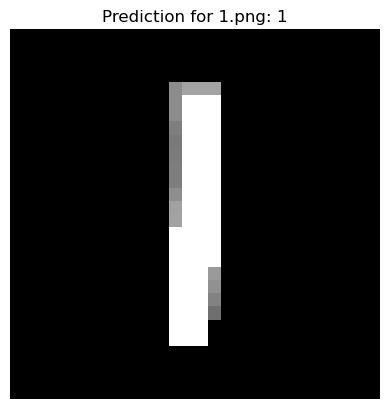

Number of features: 1
Prediction for 2.png: 2
[[ 0.   0.1 99.7  0.1  0.   0.   0.   0.   0.1  0. ]]


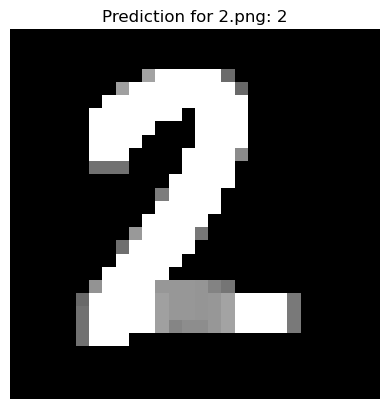

Number of features: 1
Prediction for 3.png: 3
[[ 0.   0.   0.3 99.4  0.   0.   0.   0.   0.2  0. ]]


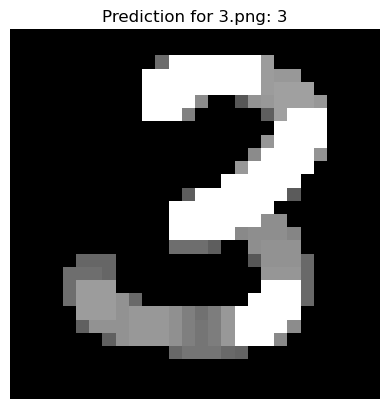

Number of features: 1
Prediction for 4.png: 4
[[ 0.1  0.1  0.1  0.5 91.8  5.3  0.1  0.1  0.8  1.1]]


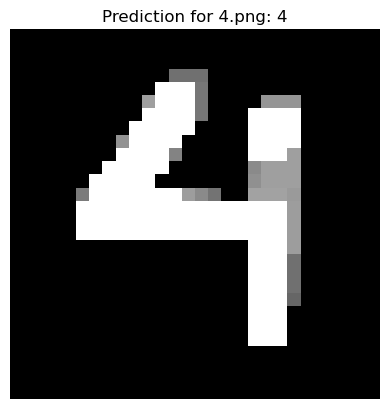

Number of features: 1
Prediction for 5_2.png: 5
[[ 0.   0.   0.   0.1  0.  99.9  0.   0.   0.   0. ]]


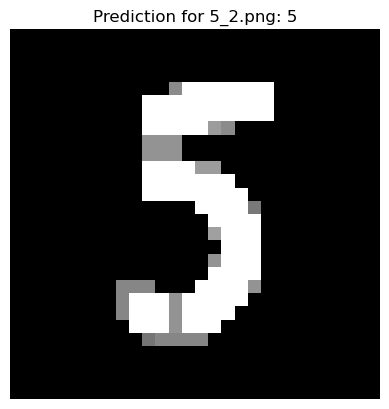

Number of features: 1
Prediction for 6.png: 6
[[ 0.   0.   0.   0.   0.   0.1 99.5  0.   0.3  0. ]]


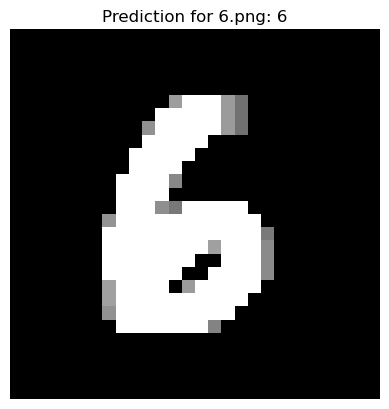

Number of features: 1
Prediction for 7.png: 7
[[ 0.   0.2  2.6  1.2  0.4  0.1  0.2 93.6  1.6  0.1]]


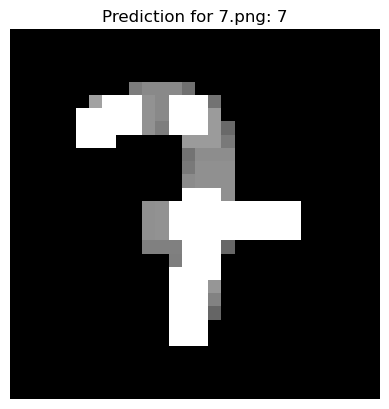

Number of features: 1
Prediction for 8.png: 8
[[ 1.2  0.1  9.   6.8  0.1  0.3  0.2  0.1 81.9  0.3]]


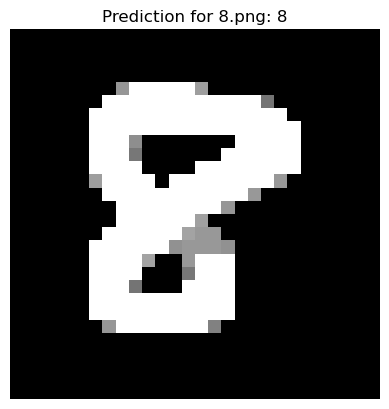

Number of features: 1
Prediction for 4_2.png: 9
[[ 0.   0.   0.   0.9  3.3  0.1  0.   0.   0.1 95.6]]


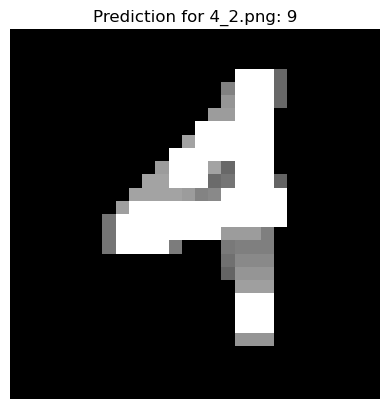

Number of features: 1
Prediction for 9_2.png: 9
[[ 0.   0.   0.   0.   0.2  0.   0.   0.1  0.  99.7]]


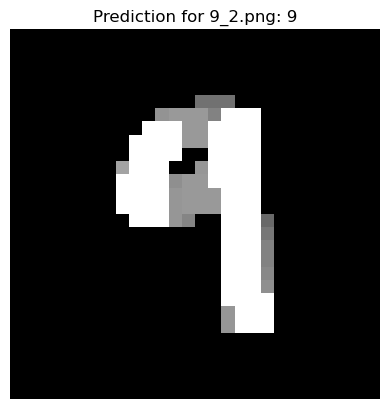

In [63]:
import matplotlib.pyplot as plt

image_paths = ['1.png','2.png','3.png', '4.png','5_2.png','6.png','7.png', '8.png','4_2.png','9_2.png']
for image_path in image_paths:
   # print(image_path)
    image_flattened_reshaped = load_image2(image_path)
    prediction = svc_clf.predict(image_flattened_reshaped)
    print(f"Prediction for {image_path}: {prediction[0]}")
    true_label = int(image_path[:-4])
    prediction_probabilities = svc_clf.predict_proba(image_flattened_reshaped)
    print(np.round(prediction_probabilities,3)*100)
    image_2D = image_flattened_reshaped.reshape(28, 28)
     # Display the processed image
    plt.imshow(image_2D, cmap='gray')  # Display the image you're making a prediction on
    plt.title(f"Prediction for {image_path}: {prediction[0]}")
    plt.axis('off')  # Hides the axis for a cleaner look
    plt.show()


In [ ]:
#some_digit = image_flattened_reshaped[0]
some_digit_image = image_flattened_reshaped.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
# plt.axis("off")
print(some_digit_image)